# StartupML - Project Adversarial.AI: Fraud Detection

# Table of contents
1. [Introduction](#introduction)
2. [Background](#Background)
3. [Data Preparation](#Data Preparation)
4. [Network X](#Network X)
5. [Other Detection Methods](#Other Detection Methods)
6. [Conclusion](#Conclusion)

 ## Introduction <a name="introduction"></a>

Due to StartupML's strict confidentiality, I am unable to share detailed code related to this project. This notebook instead highlights key themes/concepts related to the project. The goal of Adversarial.AI is to create a generalized framework that can apply machine learning techniques to a variety of adversarial use cases including information security, money laundering, and transaction fraud. The technical approach involves a cloud system that learns from many datasets. In order to generalize to multiple domains without extensive manual feature engineering, the system leverages graph representation and relies on some unsupervised feature extraction techniques.

 ## Background <a name="Background"></a>

* Network flows are were viewed through Suricata, a Network IDS, IPS and Network Security Monitoring engine. We used a dockerized version of Suricata, which allowed us to run multiple honeypot daemons on the same network interface. 
* These networks low and high interaction simulated servers connected throuh an Amazon Web Service EC2 instance.
* A T-pot is a honeypot daemon used to resemble real world sites to process and collect traffic from hackers. 

For more information on honeypots, please look at this [StartupML Honeypot Blog](https://adversarial.ai/blog/honeypot)

 ## Data Preparation <a name="Data Preparation"></a>

Imports

In [3]:
# General
import pandas as pd
import numpy as np
import json
import os
from IPython.display import Image
from glob import glob

# Graphing
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
%matplotlib inline
import pylab as pylab

# NetworkX
import networkx as nx
from multiprocessing import Pool
import itertools
import community
from multiprocessing import Pool
import itertools

# Other
import warnings
warnings.filterwarnings('ignore')

Destination and Source IP Representation

Each traffic log contained a destination and source IP address identifier. I created a python script that assigns ascending numerical values for destination and source nodes by row and creates tuples of these nodes for edge graphing. The outcome of this are three lists that are used in subsequent section to graph connections: 
* list of destination ip codes
* list of source ip codes
* list of graph edge nodes (tuples of destination and source ip codes)

The following graph would produce a total of six points (1 through 6) and lines would be drawn between them based on graph node tuples. For example, a line would be drawn:
* Twice between code dot # 1 and code dot # 2
* Three times between code dot # 3 and code dot # 4
* Once from code dot # 4 to new code dot # 5
* Twice between code dot # 2 to new code dot # 6.

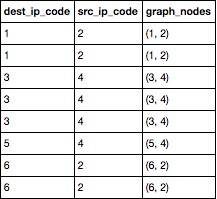

In [4]:
Image(filename='edges.png')

 ## NetworkX <a name="NetworkX"></a>

Code Below and data based off a Networkx example with social networks that can be found at this blog url: [NetworkX](https://blog.dominodatalab.com/social-network-analysis-with-networkx/) It serves as an example of the types of graphical analysis done with honeypot logs.

** By creating graphical representations of traffic flow with identifiers for fraudulent traffic, patterns can be detected that will show anomalies that represent hackers.**

In [5]:
G_fb = nx.read_edgelist("data/facebook_combined.txt", create_using = nx.Graph(), nodetype = int)

In [6]:
#Quick snapshot of the Network
print nx.info(G_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_fb)

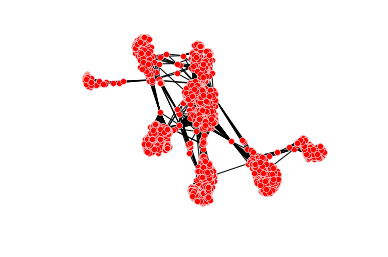

In [8]:
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)

#### Parallel Betweenness Centrality

Description from blog post:

"How do we determine who is the most “important” individual in the network. Well, that depends on the definition of 
“important”. One way to define “importance” is the individual’s betweenness centrality. The betweenness centrality 
is a measure of how many shortest paths pass through a particular vertex. The more shortest paths that pass through 
the vertex, the more central the vertex is to the network."

In [9]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [10]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [11]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

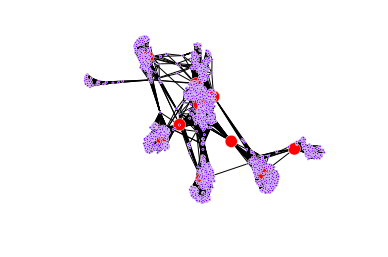

In [12]:
bt = between_parallel(G_fb)
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(G_fb.nodes())
bt_colors = [0]*len(G_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

Create Most Important Labels

Basis of function found at this url: 
[Betweenness-Centrality](http://glowingpython.blogspot.com/2013/02/betweenness-centrality.html)
* Function below defines most important label nodes and their "Betweenness_Centrality" 

In [14]:
def most_important(G):
 """ returns a copy of G with the most important nodes according to the pagerank """ 
 ranking = nx.betweenness_centrality(G).items()
 # print ranking
 r = [x[1] for x in ranking]
 m = sum(r)/len(r) # mean centrality
 t = m*10 # threshold, we keep only the nodes with 3 times the mean
 Gt = G.copy()
 for k, v in ranking:
  if v < t:
   Gt.remove_node(k)
 new_ranking = nx.betweenness_centrality(Gt).items()
 print new_ranking
 print len(new_ranking)
 return Gt

Signficance of numbers below:
* larger # indicates node is more central 
* smaller # indicates node is on the outside and has to travel across more edges to connect to other nodes

In [15]:
G_labels = most_important(G_fb)

[(0, 0.023160957400087837), (136, 0.007971014492753625), (3980, 0.0), (1684, 0.0994290733421168), (414, 0.04409937888198758), (1577, 0.012711352657004831), (171, 0.005972771190162494), (428, 0.08004109417152895), (686, 0.0), (563, 0.0901256352343309), (1718, 0.02791227492314449), (567, 0.10463877909530084), (1465, 0.012711352657004831), (58, 0.027978151075977165), (1085, 0.10945871761089154), (594, 0.08333333333333333), (348, 0.005693581780538302), (860, 0.04749670619235837), (698, 0.1002415458937198), (862, 0.019071146245059283), (483, 0.004968944099378882), (107, 0.44389390802434275), (3437, 0.10885485287659201), (2543, 0.0024154589371980675), (1912, 0.099414172783738)]
25


In [16]:
# Create network layout for visualizations
spring_pos = nx.spring_layout(G_fb)

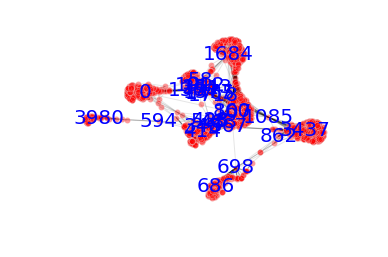

In [17]:
plt.axis("off")
# nx.draw_networkx_nodes(G_fb,spring_pos,node_color='b',alpha=0.2,node_size=8)
nx.draw_networkx_nodes(G_fb,spring_pos,node_color='r',alpha=0.4,node_size=35)
nx.draw_networkx_edges(G_fb,spring_pos,alpha=0.1)
nx.draw_networkx_labels(G_labels,spring_pos,font_size=20,font_color='b')
plt.figure(figsize=(12,8))

#### Community Detection

Description from blog post:
    
"The criteria for finding good communities is similar to that for finding good clusters. We want to maximize 
intra-community edges while minimizing inter-community edges. Formally, the algorithm tries to maximize the 
modularity of network, or the fraction of edges that fall within the community minus the expected fraction of 
edges if the edges were distributed by random. Good communities should have a high number of intra-community edges, 
so by maximizing the modularity, we detect dense communities that have a high fraction of intra-community edges."

In [18]:
parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]

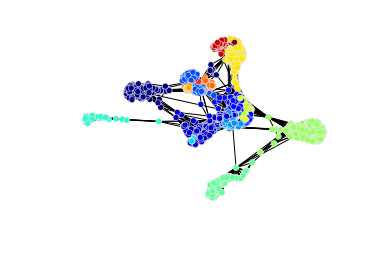

In [19]:
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

## Other Detection Methods <a name="Other Fraud Methods"></a>

Adversarial.AI also looked into other fraud detection methods related to credit card fraud. It involved writing python scripts to scrape, detect, and log credit card info that was being posted fraudulently as fake advertisements on anonymous messaging websites. 

 ## Conclusion <a name="Conclusion"></a>

Working on Adversarial.AI showed me the prevalance of information security attacks and how important and challenging it can be to detect them. Fraudulent traffic and hacking is widespread and can have drastic consequences for parties involved. By graphing network traffic through honey pot serviers, patterns can be detected that will show anomalies that represent hackers.